In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from nltk.corpus import stopwords
from textblob import TextBlob

In [3]:
df=pd.read_csv('yelp.csv')

basic preprocessing 

In [4]:
#convert to lowercase 
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'] = df['text'].str.replace('[^\w\s]','') # Remove punctuation
#Remove stop words
stop = stopwords.words('english')
stop.extend(['you','re','spa'])
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#spelling correction
#df['text'].apply(lambda x: str(TextBlob(x).correct()))

In [5]:
yelp_reviews=df[['text','stars']]

In [6]:
yelp_reviews.head()

,text,stars
0,wife took birthday breakfast excellent weather...,5
1,idea people give bad reviews place goes show p...,5
2,love gyro plate rice good also dig candy selec...,4
3,rosie dakota love chaparral dog park convenien...,5
4,general manager scott petello good egg go deta...,5


categorize stars 1-3 as 0 anything equal to greater than 4 as 1.

In [7]:
yelp_reviews['stars'] = np.where(yelp_reviews['stars']>=4,1,0)

C:\Users\Pranay\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
texts=yelp_reviews["text"].values
labels=yelp_reviews["stars"].values

#### using RNN 

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [12]:
data=yelp_reviews
max_fatures = 1000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [13]:
max_fatures=1000
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 366, 128)          128000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 366, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 383,194
Trainable params: 383,194
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
Y = pd.get_dummies(data['stars']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6700, 366) (6700, 2)
(3300, 366) (3300, 2)


In [16]:
batch_size = 100
model.fit(X_train, Y_train, epochs = 2, batch_size=batch_size)

Epoch 1/2
6700/6700 [==============================] - 282s 42ms/step - loss: 0.5917 - acc: 0.6963
Epoch 2/2
6700/6700 [==============================] - 293s 44ms/step - loss: 0.4264 - acc: 0.8103


In [17]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.48
acc: 0.77


In [18]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 92.49049429657795 %
neg_acc 51.33928571428571 %


lets test the model from a random yelp review from a local Pittsburgh restaurant,just to see how the model performs for reviews not seen before.

link to restautant yelp: https://www.yelp.com/biz/ten-penny-pittsburgh

review: What a disappointment.Let's start with the service.Our waiter Kevin was so disengaged I got the feeling he could have cared less about waiting on us.He was almost annoyed. 

In [44]:
def ReviewPredict(twt):
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=366, dtype='int32', value=0)
    #print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        return("negative")
    elif (np.argmax(sentiment) == 1):
        return("positive")    

In [45]:
twt = ['What a disappointment.   Lets start with the service.   Our waiter Kevin was so disengaged I got the feeling he could have cared less about waiting on us.   He was almost annoyed.']
ReviewPredict(twt)

'negative'

As consistent from a human judgement, the model predicted the review to be negative 

review:'Very nice and relaxing space for drinks during happy hour or for eating in with friends. It's one of the more casual places on Penn Ave in the Cultural District.' from the same local Pittsburgh restaurant. 

In [46]:
twt=['Very nice and relaxing space for drinks during happy hour or for eating in with friends. Its one of the more casual places on Penn Ave in the Cultural District.']
ReviewPredict(twt)

'positive'

As consistent from a human judgement, the model predicted the review to be positive

let us now see how negative and how positive a review is. we will use the same reviews as before 

In [84]:
def PosReviewPredict(twt):
    #vectorizing the tweet by the pre-fitted tokenizer instance
    twt = tokenizer.texts_to_sequences(twt)
    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=366, dtype='int32', value=0)
    #print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    #return 'The review is'+' '+ str(sentiment[0]*100) +'%' + ' ' + 'negative','The review is'+' '+ str(sentiment[1]*100) +'%' + ' ' + 'positive'
    objs=[sentiment[0],sentiment[1]]
    y_pos=['negative','positive']
    plt.ylabel('probability')
    plt.title('Sentimental Probability')
    return plt.bar(y_pos,objs, align='center')

review is 'Very nice and relaxing space for drinks during happy hour or for eating in with friends. It's one of the more casual places on Penn Ave in the Cultural District.'

<Container object of 2 artists>

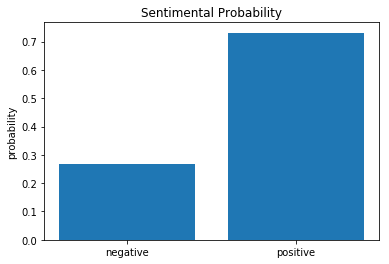

In [85]:
twt=['Very nice and relaxing space for drinks during happy hour or for eating in with friends. Its one of the more casual places on Penn Ave in the Cultural District.']
PosReviewPredict(twt)

review: What a disappointment.Let's start with the service.Our waiter Kevin was so disengaged I got the feeling he could have cared less about waiting on us.He was almost annoyed.

<Container object of 2 artists>

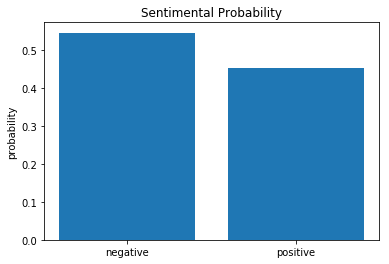

In [87]:
twt = ['What a disappointment.Lets start with the service.Our waiter Kevin was so disengaged I got the feeling he could have cared less about waiting on us.   He was almost annoyed.']
PosReviewPredict(twt)

References:

https://www.kaggle.com/poonaml/bidirectional-lstm-spacy-on-yelp-reviews

https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

https://www.kaggle.com/bsivavenu/nlp-using-glove-and-spacy

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras

https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/